In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin,STATUS_OK,Trials,hp,tpe
import mlflow
from mlflow.models import infer_signature

importacion de los datasets cifar10 de tensorflow

(50000, 32, 32, 3)
(50000, 1)


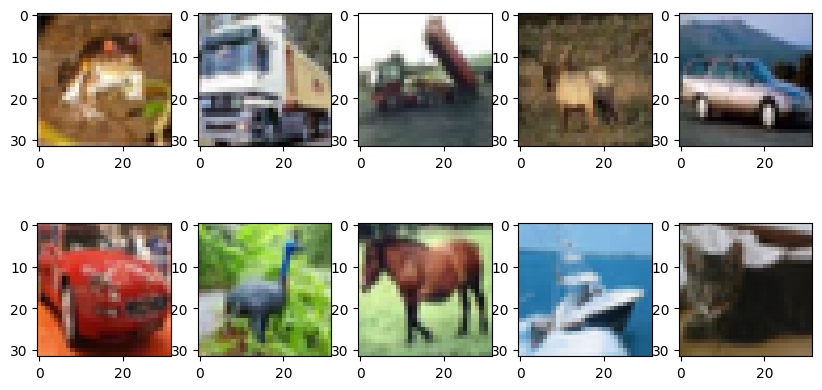

In [14]:
dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images,test_labels) = dataset.load_data()

#vemos las dimensiones con las que nos llegan el dataset
#para este caso es de 50.000 elementos con 32px x 32px, en 3 dimensiones
print(train_images.shape)

# mask = train_labels
# train_images, train_labels = train_images[train_labels.flatten()], train_labels[train_labels.flatten()]
# test_images, test_labels = test_images[test_labels.flatten()],test_labels[test_labels.flatten()]

train_images, test_images = train_images / 255.0, test_images / 255.0

#tiene 50k elementos en los cuales van desde 0 a 10 para identificar las categorias
print(train_labels.shape)

#generamos un subplot para organizar como se muestran las imagenes
fig,axes = plt.subplots(2,5,figsize=(10,5))

#iteramos las imagenes colocandolas en subplots
i=0
for ax in axes.flat:
    ax.imshow(train_images[i])
    i += 1
#mostramos las imagenes
plt.show()


A partir de las imagenes determinamos las categorias que hay en el dataset

In [ ]:
class_names = ['avion','auto','pajaro', 'gato','ciervo','perro','sapo','caballo','barco','camion']

print(train_images.shape)

(50000, 32, 32, 3)


creamos las tuplas de matrices NumPy,
como las imagenes ya se encuentran en el formato solicitado
no es necesario realizar un reshape

In [7]:
x_train = train_images
y_train = train_labels.flatten()
x_test = test_images[:5000]
y_test = test_labels[:5000].flatten()
x_val = test_images[5000:]
y_val = test_labels[5000:].flatten()
signature = infer_signature(x_train,y_train)

In [ ]:
def train_model(params,epochs,x_train,y_train,x_test,y_test,x_val,y_val):
    model1 = keras.Sequential([
        #primera capa convolucional seguido de un maxpooling
        layers.Conv2D(32, (3,3), activation='tanh', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        #segunda capa
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        #tercera capa
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        #flatten
        layers.Flatten(input_shape=(32,32,3)),
        #capa densa completamente conectada
        layers.Dense(128,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(32,activation='relu'),
        layers.Dense(10,activation='softmax')
    ])

    model1.compile(optimizer = keras.optimizers.Adam(learning_rate=params['learning_rate'],beta_1=params['beta_1'],beta_2=params['beta_2']),
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
    
    #train model with diferents params with mlfl ow tracking
    with mlflow.start_run(nested=True):
        graf = model1.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),batch_size=64,callbacks=early_stop)
        test_loss, test_accuracy = model1.evaluate(x_test,y_test)

        mlflow.log_params(params)
        mlflow.log_metrics({
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        },step=epochs)
        mlflow.keras.log_model(model1,"modelo_cnn",signature=signature)
        return {
            "loss": test_loss,
            "status": STATUS_OK,
            "model": model1
        }



In [28]:
def objective(params):
    #para que mlflow pueda registrar los parametros y resultados en cada iteracion
    result = train_model(
        params=params,
        epochs=3,
        x_train=x_train,
        y_train=y_train,
        x_test=x_test,
        y_test=y_test,
        x_val=x_val,
        y_val=y_val)
    return result

In [10]:
space = {
    "learning_rate": hp.loguniform("learning_rate", -10, -4),
    "beta_1": hp.choice("beta_1", [0.8, 0.9, 0.95]),
    "beta_2": hp.choice("beta_2", [0.99, 0.999]),
}

In [18]:
mlflow.set_experiment("/cnn_clasification")
with mlflow.start_run():
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=5,
        trials=trials
    )
    #
    best_run = sorted(trials.results,key=lambda x: x["loss"])[0]
    mlflow.log_params(best)
    mlflow.log_metric("Loss",best_run["loss"])
    mlflow.tensorflow.log_model(best_run["model"],"model",signature=signature)

    #mostrar mejores parametros
    print(f"Los mejores parametros son: {best}")
    print(f"El loss mas bajo conseguido es: {best_run['loss']}")

Epoch 1/25                                           

  1/782 ━━━━━━━━━━━━━━━━━━━━ 33:49 3s/step - accuracy: 0.0625 - loss: 2.3216
  3/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.0877 - loss: 2.3127
  5/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.0962 - loss: 2.3094
  6/782 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.1019 - loss: 2.3084
  7/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.1052 - loss: 2.3077
 10/782 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.1135 - loss: 2.3061
 12/782 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.1165 - loss: 2.3051
 14/782 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.1184 - loss: 2.3043
 16/782 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1200 - loss: 2.3036
 18/782 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1211 - loss: 2.3029
 20/782 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.1215 - loss: 2.3023
 23/782 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.1215 - loss: 2.3016
 26/782 ━━━━━━━━━━━━━

2025/10/05 16:27:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Epoch 1/25                                                                      

  1/782 ━━━━━━━━━━━━━━━━━━━━ 35:23 3s/step - accuracy: 0.1406 - loss: 2.2983
  3/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.1345 - loss: 2.2992
  4/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.1370 - loss: 2.2990
  6/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.1336 - loss: 2.2987
  8/782 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.1327 - loss: 2.2982
 11/782 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.1323 - loss: 2.2975
 14/782 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1311 - loss: 2.2976
 17/782 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.1295 - loss: 2.2974
 20/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1276 - loss: 2.2971
 23/782 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1256 - loss: 2.2971
 26/782 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1242 - loss: 2.2971
 29/782 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.1233 - loss: 2

2025/10/05 16:37:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Epoch 1/25                                                                      

  1/782 ━━━━━━━━━━━━━━━━━━━━ 31:46 2s/step - accuracy: 0.1250 - loss: 2.2923
  3/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.1215 - loss: 2.2929
  5/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.1232 - loss: 2.2955
  7/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.1286 - loss: 2.2963
  9/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.1302 - loss: 2.2966
 11/782 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.1300 - loss: 2.2969
 13/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1291 - loss: 2.2972
 15/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1284 - loss: 2.2972
 18/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1273 - loss: 2.2970
 20/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1268 - loss: 2.2968
 22/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.1264 - loss: 2.2965
 25/782 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1261 - loss: 2

2025/10/05 16:46:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Epoch 1/25                                                                      

  1/782 ━━━━━━━━━━━━━━━━━━━━ 33:35 3s/step - accuracy: 0.0938 - loss: 2.3113
  3/782 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.0877 - loss: 3.4720
  5/782 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.0948 - loss: 3.3923
  8/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.0986 - loss: 3.2177
 11/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.0967 - loss: 3.0894
 14/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.0963 - loss: 2.9939
 17/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.0973 - loss: 2.9207
 20/782 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.0978 - loss: 2.8640
 22/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.0981 - loss: 2.8322
 24/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.0981 - loss: 2.8043
 25/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.0981 - loss: 2.7916
 27/782 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.0979 - loss: 2

2025/10/05 16:50:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Epoch 1/25                                                                      

  1/782 ━━━━━━━━━━━━━━━━━━━━ 1:06:57 5s/step - accuracy: 0.0938 - loss: 2.2989
  2/782 ━━━━━━━━━━━━━━━━━━━━ 1:13 94ms/step - accuracy: 0.0820 - loss: 2.2991 
  3/782 ━━━━━━━━━━━━━━━━━━━━ 1:17 99ms/step - accuracy: 0.0790 - loss: 2.3013
  4/782 ━━━━━━━━━━━━━━━━━━━━ 1:09 90ms/step - accuracy: 0.0778 - loss: 2.3033
  5/782 ━━━━━━━━━━━━━━━━━━━━ 1:02 80ms/step - accuracy: 0.0804 - loss: 2.3037
  6/782 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - accuracy: 0.0830 - loss: 2.3043 
  7/782 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - accuracy: 0.0849 - loss: 2.3047
  8/782 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.0853 - loss: 2.3050
  9/782 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.0858 - loss: 2.3051
 10/782 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.0868 - loss: 2.3051
 11/782 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.0879 - loss: 2.3049
 12/782 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.0888 -

2025/10/05 16:55:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



100%|██████████| 5/5 [32:59<00:00, 395.92s/trial, best loss: 0.8465031981468201]

2025/10/05 16:55:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Los mejores parametros son: {'beta_1': np.int64(1), 'beta_2': np.int64(1), 'learning_rate': np.float64(0.0005598216959829994)}
El loss mas bajo conseguido es: 0.8465031981468201


In [27]:
# experiment_name = "/cnn_clasification"
# experiment = mlflow.get_experiment_by_name(experiment_name)
# runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
# print(runs[['run_id', 'status', 'start_time']])
# model_uri = 'runs:/ab859b8809e74d9d98b2759ccd44871a/model'
# loaded_model = mlflow.pyfunc.load_model(model_uri)
# y_pred = loaded_model.predict(x_test)
# print(y_pred)
# y_test = test_labels.flatten()

#tabularizar datos
for trial in trials.trials:
    print(trial)

# predichos = []
# reales = []
# clase_pred = []
# for i in range(0,len(y_pred)):
#     clase_pred.append(np.argmax(y_pred[i]))
#     if np.argmax(y_pred[i]) == y_test[i]:
#         predichos.append(1)
#         reales.append(1)
#     else:
#         predichos.append(1)
#         reales.append(0)

    
# print("La cantidad de aciertos es:",np.count_nonzero(reales))

# #grafica de las clases acertadas
# fig, axes = plt.subplots(2,5,figsize=(10,5))
# for i,ax in enumerate(axes.flat):
#     ax.imshow(x_test[i])
#     clase_predecida = class_names[clase_pred[i]]
#     clase_real = class_names[y_test[i]]
#     color = "green" if clase_predecida == clase_real else "red"
#     ax.set_title(f"{clase_predecida}\n {clase_real}", color=color)
    
# plt.show()

# #grafico de la matriz de confusion
# predichos = np.array(predichos).reshape(10000)
# reales = np.array(reales).reshape(10000)
# cm = confusion_matrix(predichos,reales)
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels = ['Negative', 'Positive'],
#             yticklabels = ['Negative', 'Positive'])


# plt.xlabel("prediccion")
# plt.ylabel('Real')
# plt.title("Matriz de confusion")
# plt.show()

# #graficos para la precision y el error
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.plot(graf.history['accuracy'], label='Entrenamiento')
# ax1.plot(graf.history['val_accuracy'], label='Validacion')
# ax1.set_title('Curva de precision')
# ax1.set_xlabel('Epoca')
# ax1.set_ylabel('Precision')
# ax1.legend()

# ax2.plot(graf.history['loss'], label='Entrenamiento')
# ax2.plot(graf.history['val_loss'], label='Validacion')
# ax2.set_title('Curva de perdida')
# ax2.set_xlabel('Epoca')
# ax2.set_ylabel('Loss')
# ax2.legend()

# plt.show()


{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.8465031981468201, 'status': 'ok', 'model': <Sequential name=sequential_4, built=True>}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'beta_1': [np.int64(0)], 'beta_2': [np.int64(0)], 'learning_rate': [np.int64(0)]}, 'vals': {'beta_1': [np.int64(1)], 'beta_2': [np.int64(1)], 'learning_rate': [np.float64(0.0005598216959829994)]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2025, 10, 5, 19, 22, 40, 650000), 'refresh_time': datetime.datetime(2025, 10, 5, 19, 28, 49, 838000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 0.883668065071106, 'status': 'ok', 'model': <Sequential name=sequential_5, built=True>}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'beta_1': [np.int64(1)], 'beta_2': [np.int64(1)], 'learning_rate': [np.int64(1)]}, 'vals': {'beta_1': [np.int64(2)], 'beta_2': [np.int64(1)], 'l